# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Deep Learning Para Aplicações de IA com PyTorch e Lightning</font>

## <font color='blue'>Lab 2 - Parte 1</font>
## <font color='blue'>Regressão Logística x Torchvision Para Reconhecimento de Imagens</font>

Obs: Este Jupyter Notebook pode ser executado localmente ou na nuvem.

![title](imagens/Lab2.png)

Um pouco sobre a Regressão Logística:

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

## Instalando e Carregando os Pacotes

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.13


In [2]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# !pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
# !pip install -q -U watermark

In [3]:
# Imports
import math
import pickle
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

numpy     : 1.21.5
matplotlib: 3.5.2



## Funções Auxiliares Para Carga e Preparação dos Dados

In [5]:
# Função para carregar os dados
def carrega_dados(filename):
    
    # Caminho das imagens
    filename = "cifar-10-batches-py/" + filename
    
    # Carrega as imagens
    with open(filename, mode = 'rb') as file:
        data = pickle.load(file, encoding = 'bytes')

    # Carrega imagem no formato bruto
    raw_images = data[b'data']

    # Obtém os números de classe para cada imagem e converte para array (tensor) numpy
    y = np.array(data[b'labels'])

    # Converte as imagens brutas dos arquivos de dados em pontos flutuantes (melhora a precisão dos cálculos)
    raw_float = np.array(raw_images, dtype = float) / 255.0

    # Reshape da matriz para 4 dimensões
    images = raw_float.reshape([-1, 3, 32, 32])

    # Reordena os índices do array
    images = images.transpose([0, 2, 3, 1])

    # Shape final
    X = images.reshape((images.shape[0], 3*32*32))
    
    return X, y

In [6]:
# Função de formatação dos dados
def formata_dados(X, Y, v0, v1):
    
    # Limites
    lg = max(v0, v1)
    
    # Lista de índices
    indices = []
    
    # Loop para extração dos índices
    for i in range(len(Y)):
        if Y[i] == v0 or Y[i] == v1:
            indices.append(i)
            
    # Squeeze dos tensores (ajuste do shape)
    X = np.squeeze(np.take(X, indices, axis = 0))
    Y = np.squeeze(np.floor(np.divide(np.take(Y, indices, axis=0), lg)))
    
    return X, Y

### Geração dos Batchs de Imagens

In [7]:
# Valores para definir os dados que serão usados
bloco_start = 0          
bloco_end = 3          
TRAIN_BATCH = 1      

In [8]:
# Carrega os dados
x_treino, y_treino = carrega_dados(f"data_batch_{TRAIN_BATCH}")

In [9]:
# Formata e prepara os dados
x_treino, y_treino = formata_dados(x_treino, y_treino, bloco_start, bloco_end)

In [10]:
x_treino

array([[0.49019608, 0.49019608, 0.45490196, ..., 0.56470588, 0.45490196,
        0.3372549 ],
       [0.43137255, 0.40784314, 0.38039216, ..., 0.2       , 0.18823529,
        0.24313725],
       [0.98823529, 0.03137255, 0.16470588, ..., 0.98431373, 0.22745098,
        0.34509804],
       ...,
       [0.68235294, 0.70588235, 0.76862745, ..., 0.5254902 , 0.50196078,
        0.41960784],
       [0.82745098, 0.90196078, 0.92941176, ..., 0.85490196, 0.92156863,
        0.94901961],
       [0.07058824, 0.23137255, 0.05098039, ..., 0.22745098, 0.23137255,
        0.14509804]])

In [11]:
y_treino

array([1., 1., 1., ..., 0., 0., 1.])

## Construindo o Modelo de Regressão Logística Sem o Uso de Frameworks

### 1- Módulo de Treinamento e Otimização

In [12]:
# Função para treinamento do modelo
def fit(X, Y, epsilon, learning_rate, start, end, beta = 0, max = 2000):
    
    # Valores de X e Y
    X = X[start:end]
    Y = Y[start:end]
    
    # Número de pontos de dados
    data_points = X.shape[0]
    
    # Número de dimensões
    dimensions = X.shape[1]

    # Lista para armazenar o likelihood
    likelihood0 = []

    # Valores de controle
    delta = 0
    itr = 0
    itrs = []
    
    # Inicialização de beta (pesos) com valores randômicos
    if beta == 0:
        beta = []
        for i in range(dimensions):
            beta.append(random.random() * 0)
        beta = np.array(beta)

    # Otimização da função de perda com a descida do gradiente
    while True:
        
        # Calcula os gradientes
        grad = calcula_gradiente(beta, X, Y) 

        # Atualiza beta com o novo valor do gradiente e ajusta o tamanho da mudança com a taxa de aprendizado
        beta = beta + (learning_rate * grad)
        
        # Calcula o log likelihood (erro do modelo)
        log = func_log_likelihood(beta, X, Y) 

        # Inclui o valor na lista
        likelihood0.append(log)
        
        # Ajusta o número de iterações
        itr += 1
        itrs.append(itr)
        
        # Calcula a norma da matriz de gradientes
        # https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html
        delta = np.linalg.norm(grad) 

        # Se alcançamos o limite, finaliza o treinamento
        if delta < epsilon or itr > max:
            break
    
    return beta, likelihood0, itrs

### 2- Módulo da Função de Perda com Log Likelihood

Leia o manual em pdf no Capítulo 3.

In [13]:
# Função para cálculo do Log Likelihood
def func_log_likelihood(beta, X, Y):
    
    # Calcula dados entrada x matriz de pesos
    t = np.dot(X, beta.T)
    
    # Subtrai o bias (viés)
    w = np.subtract(Y, 1)
    
    # Calcula o peso w
    w = np.dot(w, t)

    # Prepara o valor do bias
    m = np.power(math.e, -t)
    
    # Adiciona o bias
    m = np.add(1, m)
    
    # Calcula o Log Likelihood 
    z = np.log(m)
    
    # Soma os valores de z (erros do modelo)
    z = np.sum(z)

    return w - z

### 3- Módulo da Descida do Gradiente

Leia o manual em pdf no Capítulo 3.

In [14]:
# Função para cálculo do gradiente
# Observe as operações com tensores NumPy
def calcula_gradiente(beta, X, Y):
    
    # Retira o bias antes dos cálculos
    z = np.subtract(Y, 1)
    
    # Calcula o novo valor do peso w
    w = np.power(math.e, np.dot(-X, beta.T))
    
    # O valor de p é quanto deve ser modificado no valor do peso w (é a derivada)
    p = np.divide(w, np.add(1, w))
    
    # O valor de q é o tensor final
    q = z + p

    # Calcula delta (quanto os pesos devem mudar na próxima passada)
    delta = np.dot(q, X)

    return delta

### 4- Módulo de Teste do Modelo (Previsões)

y = beta . X

In [15]:
# Função de teste do modelo
def predict(X, Y, beta):
    
    # Calcula z (previsão bruta do modelo)
    z = np.dot(X, beta)
    
    # Função da Regressão Logística 
    # Usamos o valor de z para fazer as previsões de y
    predY = (1/(1+np.exp(-z)))
    
    # Arredonda o valor
    predY = np.around(predY)
   
    # Matrizes de acertos e erros do modelo
    acertos = [[], []]
    erros = [[], []]
    
    # Loop de previsões
    for i in range(len(X)):
        if predY[i] == Y[i]:
            acertos[int(Y[i])].append(i)
        else:
            erros[int(Y[i])].append(i)
            
    return acertos, erros

### 5- Módulo de Avaliação do Modelo

In [16]:
# Função de avaliação
def avalia_modelo(correct, incorrect, total):
    
    # Acertos do modelo
    correct = len(correct[0]), len(correct[1])
    
    # Erros do modelo
    incorrect = len(incorrect[0]), len(incorrect[1])
    
    # Acurácia
    acc = ((correct[0] + correct[1]) / total) * 100
    print(f"Acurácia do Modelo: {acc}%")

## Treinamento

### Definição dos Hiperparâmetros

In [17]:
# Critério de parada
valor_epsilon = 0.02 

O parâmetro epsilon (também chamado de tolerância de convergência ou tolerância para critérios de parada) é um valor limite usado para determinar quando o algoritmo de otimização deve parar. É usado para controlar a precisão da otimização, com um valor menor de epsilon resultando em uma otimização mais precisa, mas exigindo mais tempo de computação.

Esse critério de parada é usado para garantir que a otimização não continue indefinidamente, pois os parâmetros do modelo acabarão por atingir um ponto em que não mudam significativamente entre as iterações.

In [18]:
# Controle a velocidade do treinamento
valor_taxa_aprendizado = 0.000005 

In [19]:
# Ponto de início dos dados para o treinamento
ponto_inicio = 0

In [20]:
# Ponto final dos dados para o treinamento
ponto_fim = len(x_treino[0])

In [21]:
# Número máximo de iterações
valor_iter = 1000

### Loop de Treinamento

In [22]:
%%time
modelo = fit(x_treino, 
             y_treino, 
             valor_epsilon, 
             valor_taxa_aprendizado, 
             ponto_inicio, 
             ponto_fim, 
             max = valor_iter) 

CPU times: user 1min 17s, sys: 4.76 s, total: 1min 21s
Wall time: 21.1 s


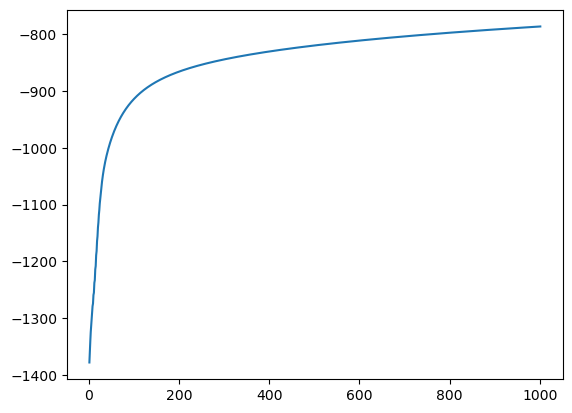

In [23]:
# Plot
plt.plot(modelo[2], modelo[1])
plt.show()

### Teste do Modelo

In [24]:
# Carrega um novo batch de dados
x_teste, y_teste = carrega_dados("test_batch")

In [25]:
# Valores para definir os dados que serão usados
bloco_start = 0          
bloco_end = 3           

In [26]:
# Formata os dados
x_teste, y_teste = formata_dados(x_teste, y_teste, bloco_start, bloco_end)

In [27]:
# Faz as previsões com o modelo e extrai acertos e erros
acertos, erros = predict(x_teste, y_teste, modelo[0])

In [28]:
# Avalia o modelo
avalia_modelo(acertos, erros, len(y_teste))

Acurácia do Modelo: 81.65%


## Previsões com o Modelo Treinado

In [29]:
# Função para carregar um novo batch de imagens
def carrega_novas_imagens(filename):
    
    # Batch de imagens
    filename = "cifar-10-batches-py/" + filename
    
    # Loop
    with open(filename, mode = 'rb') as file:
        data = pickle.load(file, encoding = 'bytes')

    # Imagens originais
    raw_images = data[b'data']
    raw_images = raw_images.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
    
    # Labels
    labels = np.array(data[b'labels'])
    
    return raw_images, labels

In [30]:
# Executa a função
images, labels = carrega_novas_imagens("test_batch")

In [31]:
# Loop
n_img = []
for i in range(len(labels)):
    if labels[i] == bloco_start or labels[i] == bloco_end:
        n_img.append(images[i])

Esta é a função de distribuição de log-verossimilhança. O eixo x é o número de iterações feitas na fase de treinamento, o eixo y é o valor que está sendo aproximado pela função log-verossimilhança. O objetivo é fazer com que a derivada dessa função se aproxime de 0.

Selecionando algumas imagens classificadas corretamente: 


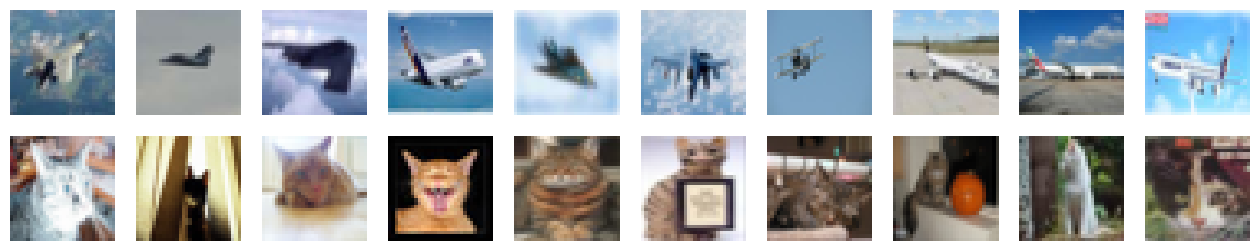

In [32]:
print("Selecionando algumas imagens classificadas corretamente: ")
fig, axes1 = plt.subplots(2,10,figsize=(16,3))
for j in range(2):
    for k in range(10):
        i = random.choice(acertos[j])
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(n_img[i:i+1][0])
plt.show()

Selecionando algumas imagens classificadas incorretamente: 


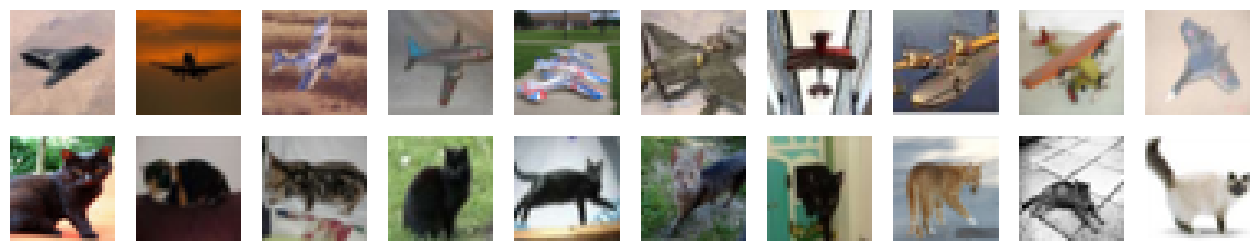

In [33]:
print("Selecionando algumas imagens classificadas incorretamente: ")
fig, axes1 = plt.subplots(2,10,figsize=(16,3))
for j in range(2):
    for k in range(10):
        i = random.choice(erros[j])
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(n_img[i:i+1][0])

plt.show()

## Conclusão da Parte 1 

Conseguimos Acurácia de 81.65%. Será que conseguimos melhorar essa performance com Deep Learning? A resposta está na parte 2 do Lab.

# Fim